In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set_style('darkgrid')
np.set_printoptions(precision=3)
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer, OrdinalEncoder

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import shap
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve


In [2]:
dataset_path1 = "/kaggle/input/tabular-playground-series-may-2022/train.csv"
dataset_path2 = "/kaggle/input/tabular-playground-series-may-2022/test.csv"
datos = pd.read_csv(dataset_path1, index_col='id')
test = pd.read_csv(dataset_path2, index_col='id')

In [3]:
def partir_columna_string(df, columna = 'f_27'):
  num_caracteres = df[columna].str.len().max()
  for i in range(num_caracteres):
    df[f'Posicion_{i}'] = df[columna].str.get(i).apply(ord) - ord('A')

  df['car_dif'] = df[columna].apply(lambda x: len(set(x)))

In [4]:
for df in [datos, test]:

    partir_columna_string(df)
    

    df['i_02_21'] = (df.f_21 + df.f_02 > 5.2).astype(int) - (df.f_21 + df.f_02 < -5.3).astype(int)
    df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)
    i_00_01_26 = df.f_00 + df.f_01 + df.f_26
    df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)

    df.drop(columns='f_27', inplace = True)
    
features = datos.drop(columns = 'target').columns

In [5]:
X = datos.drop(labels=["target"], axis=1)
y = datos["target"]

seed = 42

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, train_size = 0.4)

In [7]:
model = model = LGBMClassifier(n_estimators=5000,
                               min_child_samples=80, 
                               random_state=seed)
model.fit(X_train,y_train)
y_val_pred =  model.predict_proba(X_test)[:,1]
score = roc_auc_score(y_test, y_val_pred)
print(f"Validation AUC:{(score):.3f}")

Validation AUC:0.996


In [8]:
X_sampled = X_test.sample(20000, random_state=1307)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sampled)

In [9]:
shap_interaction = explainer.shap_interaction_values(X_sampled)

In [10]:
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap, index=X.columns, columns=X.columns)

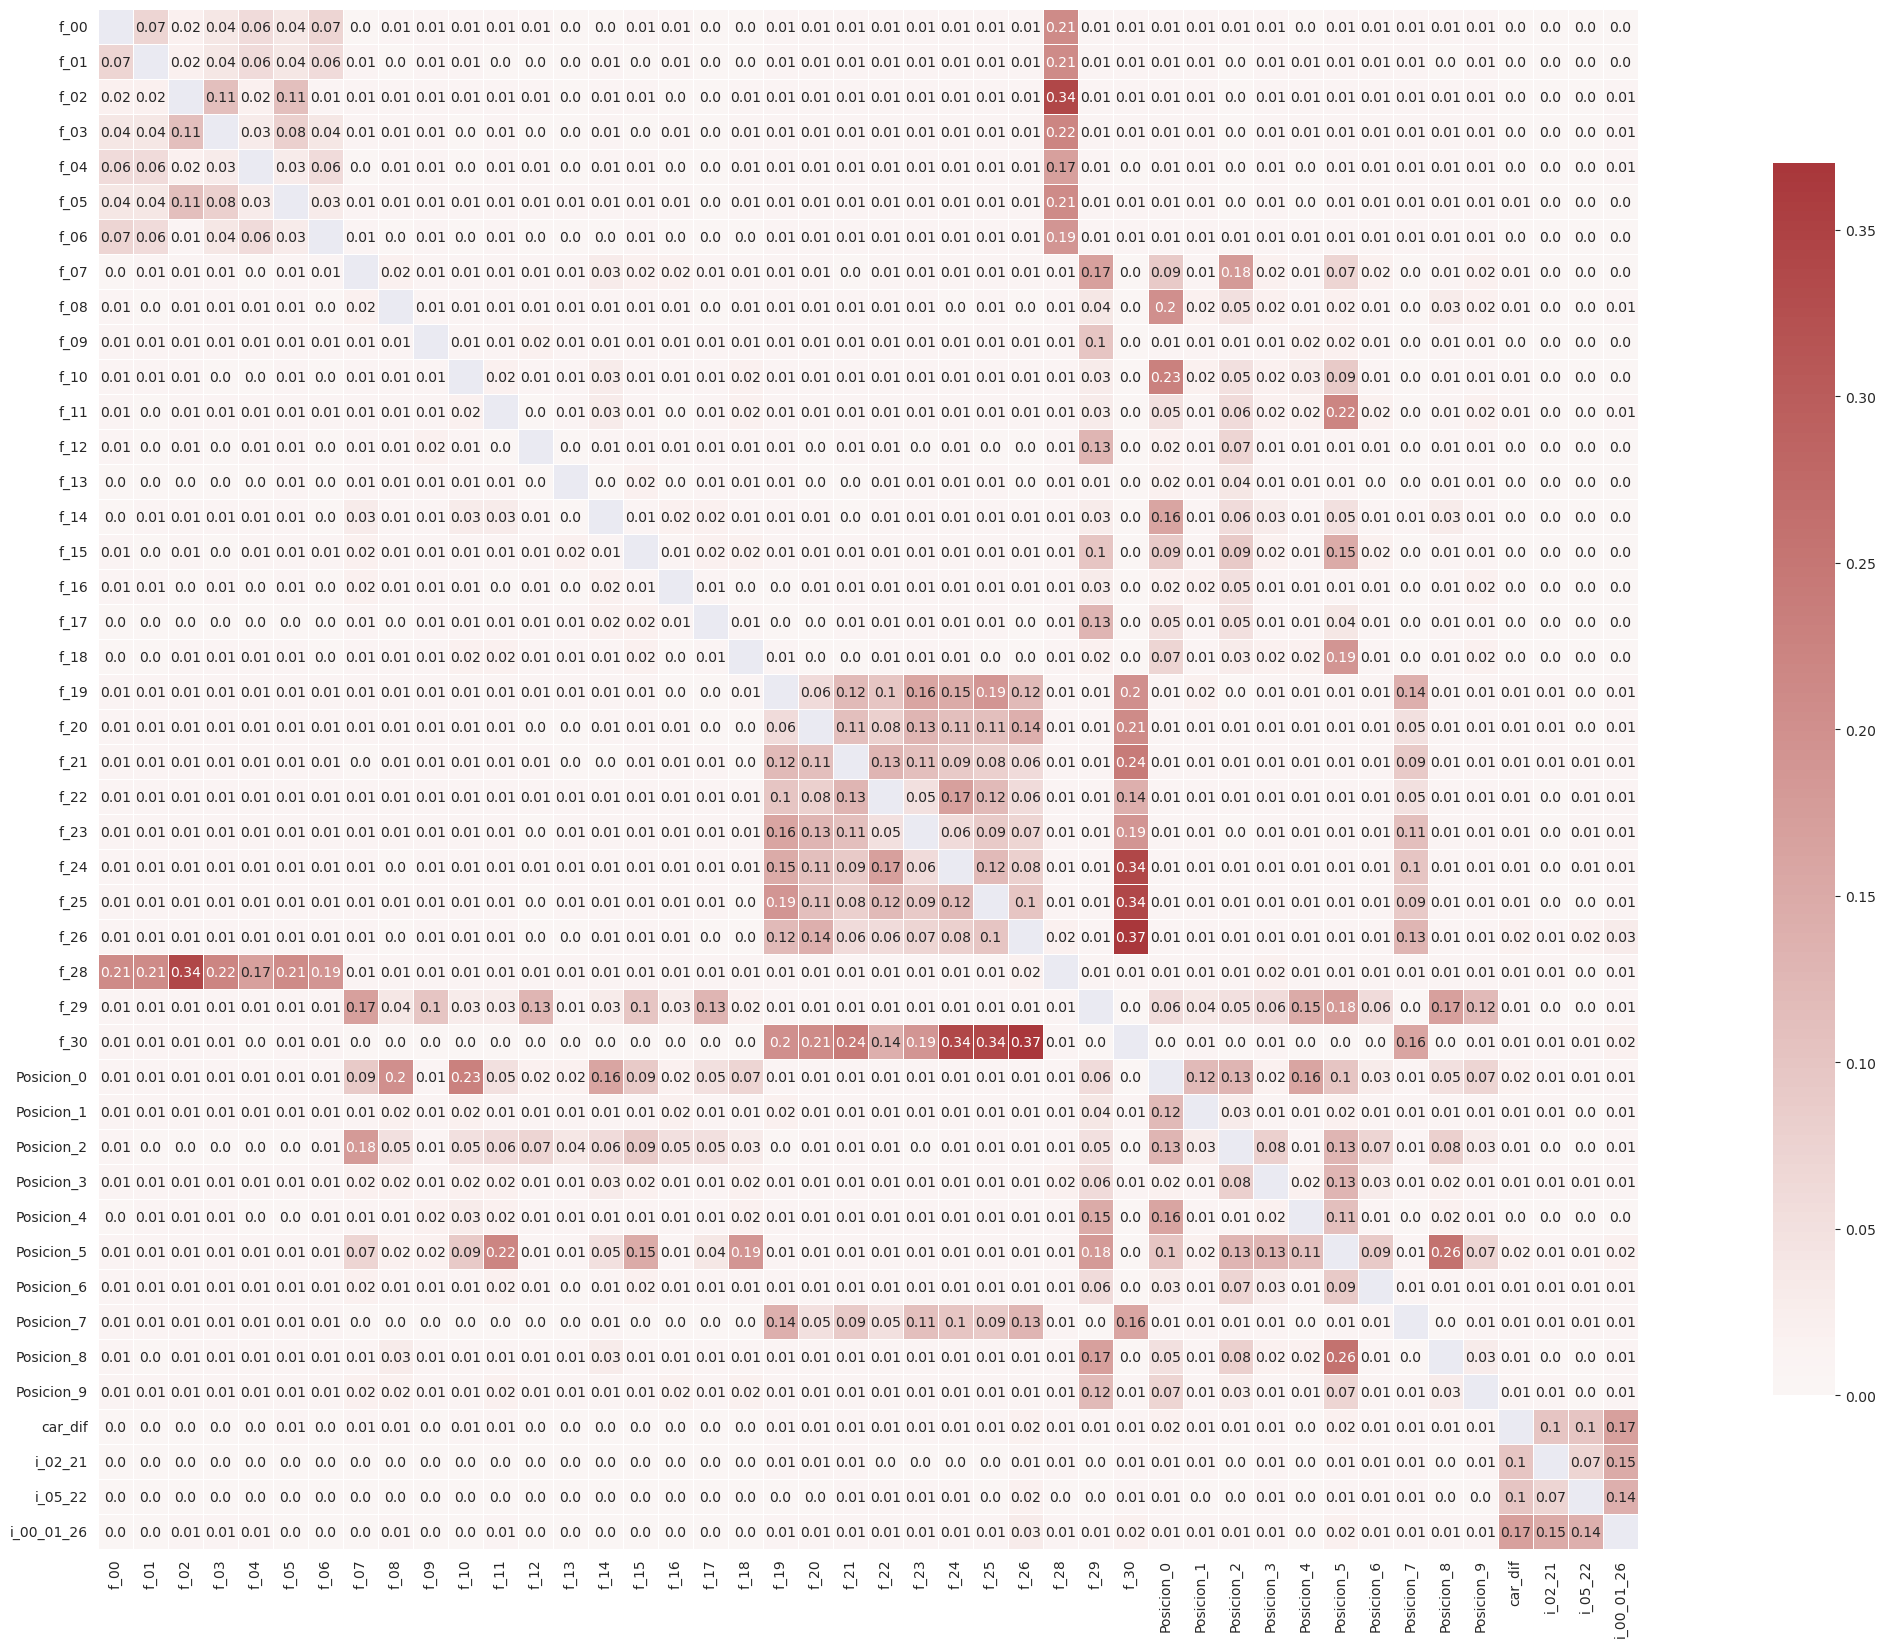

In [11]:
plt.figure(figsize=(35,20))
sns.heatmap(df.round(decimals=2), mask=np.eye(len(df)), square=True,
            center=0, annot=True, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8})
plt.tick_params(axis='x', rotation=90)

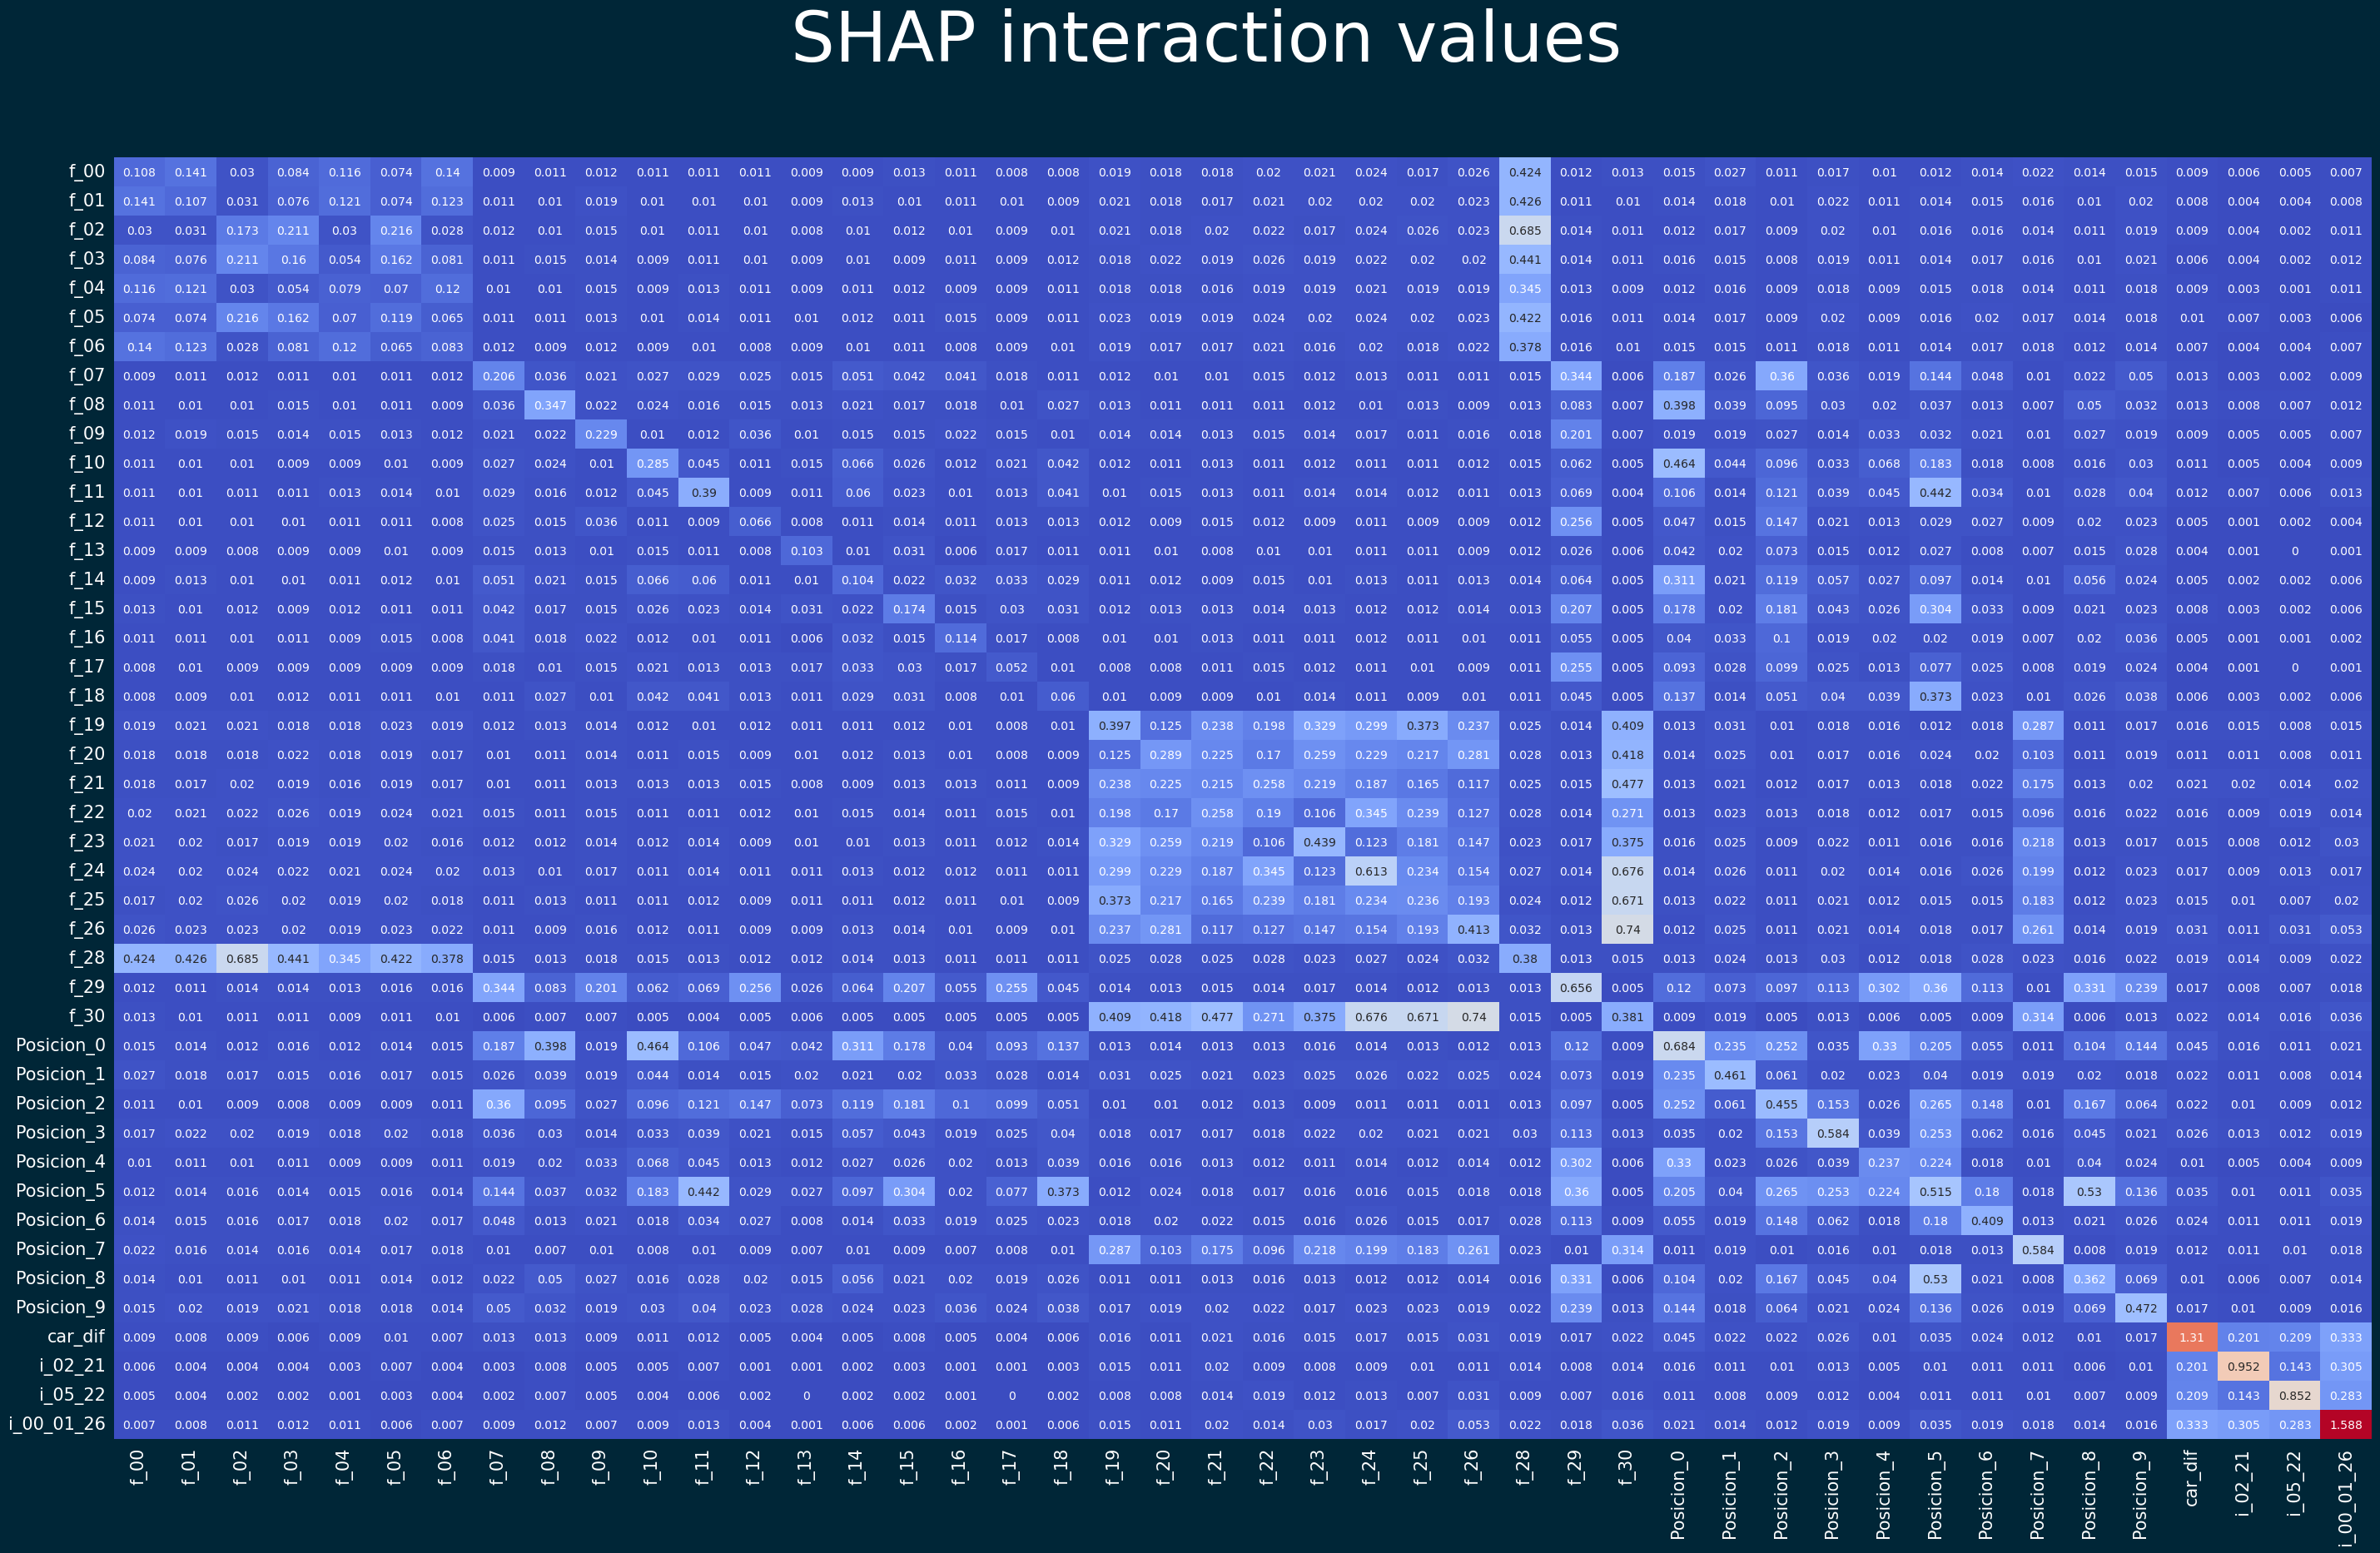

In [12]:
df.where(df.values == np.diagonal(df),df.values*2, inplace=True)

# display 
fig = plt.figure(figsize=(35, 20), facecolor='#002637', edgecolor='r')
ax = fig.add_subplot()
sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=False, ax=ax, )
ax.tick_params(axis='x', colors='w', labelsize=15, rotation=90)
ax.tick_params(axis='y', colors='w', labelsize=15)

plt.suptitle("SHAP interaction values", color="white", fontsize=60, y=0.97)
plt.yticks(rotation=0) 
plt.show()